## Introduction 

Hello! This is my very first Kernel. It is meant to give a grasp of a problem of speech representation. I'd also like to take a look on a features specific to this dataset. 

Content:<br>
* [1. Visualization of the recordings - input features](#visualization)
   * [1.1. Wave and spectrogram](#waveandspectrogram)
   * [1.2. MFCC](#mfcc)
   * [1.3. Sprectrogram in 3d](#3d)
   * [1.4. Silence removal](#resampl)
   * [1.5. Resampling - dimensionality reductions](#silenceremoval)
   * [1.6. Features extraction steps](#featuresextractionsteps)
* [2. Dataset investigation](#investigations)
   * [2.1. Number of files](#numberoffiles)
   * [2.2. Mean spectrograms and fft](#meanspectrogramsandfft)
   * [2.3. Deeper into recordings](#deeper)
   * [2.4. Length of recordings](#len)
   * [2.5. Note on Gaussian Mixtures modeling](#gmms)
   * [2.6. Frequency components across the words](#components)
   * [2.7. Anomaly detection](#anomaly)
* [3. Where to look for the inspiration](#wheretostart)

All we need is here:

In [4]:
%config IPCompleter.greedy=True

import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

In [5]:
train_audio_path = 'train/audio'
test_audio_path = 'test/audio'
filename = '/yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [6]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5,0,'Seconds')

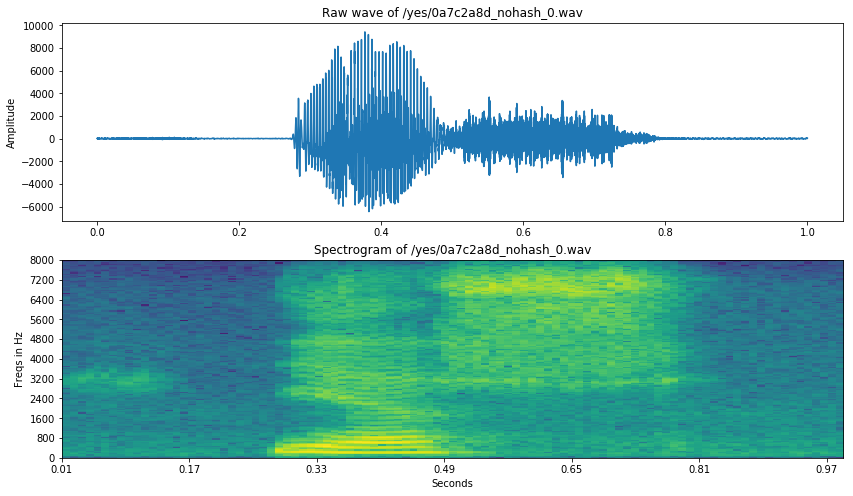

In [7]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')


In [8]:
def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):
    """Filters out non-voiced audio frames.
    Given a webrtcvad.Vad and a source of audio frames, yields only
    the voiced audio.
    Uses a padded, sliding window algorithm over the audio frames.
    When more than 90% of the frames in the window are voiced (as
    reported by the VAD), the collector triggers and begins yielding
    audio frames. Then the collector waits until 90% of the frames in
    the window are unvoiced to detrigger.
    The window is padded at the front and back to provide a small
    amount of silence or the beginnings/endings of speech around the
    voiced frames.
    Arguments:
    sample_rate - The audio sample rate, in Hz.
    frame_duration_ms - The frame duration in milliseconds.
    padding_duration_ms - The amount to pad the window, in milliseconds.
    vad - An instance of webrtcvad.Vad.
    frames - a source of audio frames (sequence or generator).
    Returns: A generator that yields PCM audio data.
    """
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    # We use a deque for our sliding window/ring buffer.
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
    # NOTTRIGGERED state.
    triggered = False

    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)
#         sys.stdout.write('1' if is_speech else '0')
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            # If we're NOTTRIGGERED and more than 90% of the frames in
            # the ring buffer are voiced frames, then enter the
            # TRIGGERED state.
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
#                 sys.stdout.write('+(%s)' % (ring_buffer[0][0].timestamp,))
                # We want to yield all the audio we see from now until
                # we are NOTTRIGGERED, but we have to start with the
                # audio that's already in the ring buffer.
                for f, s in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            # We're in the TRIGGERED state, so collect the audio data
            # and add it to the ring buffer.
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            # If more than 90% of the frames in the ring buffer are
            # unvoiced, then enter NOTTRIGGERED and yield whatever
            # audio we've collected.
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
#                 sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
                triggered = False
                yield b''.join([f.bytes for f in voiced_frames])
                ring_buffer.clear()
                voiced_frames = []
#     if triggered:
#         sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
#     sys.stdout.write('\n')
    # If we have any leftover voiced audio when we run out of input,
    # yield it.
    if voiced_frames:
        yield b''.join([f.bytes for f in voiced_frames])


In [9]:
import webrtcvad
import collections
import contextlib
import sys
import wave

class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration
        
def read_wave(path):
    """Reads a .wav file.
    Takes the path, and returns (PCM audio data, sample rate).
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate
    
def write_wave(path, audio, sample_rate):
    """Writes a .wav file.
    Takes path, PCM audio data, and sample rate.
    """
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)
    
def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.
    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n
        
def detectSilence(srcpath,filename):
    
    audio, sample_rate = read_wave(srcpath + filename)
    vad = webrtcvad.Vad(2)
    frames = frame_generator(30, audio, sample_rate)
    frames = list(frames)
    segments = vad_collector(sample_rate, 30, 300, vad, frames)
    isSilence = True
    for i, segment in enumerate(segments):
        path = 'data/SilenceRemoved/'+filename.strip('.wav')+'-%002d.wav' % (i,)
#         print(' Writing %s' % (path,))
        write_wave(path, segment, sample_rate)
        isSilence = False

    return isSilence
    
# silence file  : clip_0004c6707, clip_0003c7122, clip_000dcdd2c
filename = '/clip_0000adecb.wav'
# print(stripSilence('data/' + str(test_audio_path), filename))
print(detectSilence('data/' + str(test_audio_path), filename))

False


In [10]:
ipd.Audio(samples, rate=sample_rate)

I consider that some *VAD* (Voice Activity Detection) will be really useful here. Although the words are short, there is a lot of silence in them. A decent *VAD* can reduce training size a lot, accelerating training speed significantly.
Let's cut a bit of the file from the beginning and from the end. and listen to it again (based on a plot above, we take from 4000 to 13000):

In [11]:
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

In [12]:
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [13]:
ipd.Audio(samples, rate=sample_rate)

In [14]:
ipd.Audio(resampled, rate=new_sample_rate)

Almost no difference!

This is how we reduced dataset size twice!

## 1.6. Features extraction steps
<a id="featuresextractionsteps"></a> 

I would propose the feature extraction algorithm like that:
1. Resampling
2. *VAD*
3. Maybe padding with 0 to make signals be equal length
4. Log spectrogram (or *MFCC*, or *PLP*)
5. Features normalization with *mean* and *std*
6. Stacking of a given number of frames to get temporal information

It's a pity it can't be done in notebook. It has not much sense to write things from zero, and everything is ready to take, but in packages, that can not be imported in Kernels.

In [15]:
# import webrtcvad
def extractmfccfeatures(filename):
    new_sample_rate = 8000
    sample_rate, samples = wavfile.read(filename)
    resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))
#     vad = webrtcvad.Vad(1)
    zeroList = []
    if len(resampled)<8000:
        delta = 8000-len(resampled)
        padd = int(delta/2)
        zeroList = [0]*padd

    samplesWithPad = np.concatenate([np.array(zeroList),resampled,np.array(zeroList)])
#     if(vad.is_speech(resampled, new_sample_rate))
    S = librosa.feature.melspectrogram(samplesWithPad, sr=new_sample_rate, n_mels=128)
    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    mfcc = np.vstack([mfcc, delta2_mfcc])
    transposed_mfcc = mfcc.transpose()
    return transposed_mfcc

mfcc = extractmfccfeatures(str(train_audio_path) + '/happy/0ac15fe9_nohash_0.wav')
print(np.shape(mfcc))
pca = PCA(n_components=13)
mfcc_principal = pca.fit_transform(mfcc)
print(np.shape(mfcc_principal))

(16, 26)
(16, 13)


In [17]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
dirs.remove('_background_noise_')
print(dirs)
print(len(dirs))
# to_keep = 'yes no up down left right on off stop go'.split()

target = []
mfcc_all = []
wavesLenList = []
t=10
for direct in dirs:
    if direct=='_background_noise_':
        continue
    try:
        t = dirs.index(direct)
    except ValueError:
        t = 31

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    wavesLenList += [len(waves)]
    for wav in waves:
        wavpath = str(train_audio_path) + '/' + direct + '/' + wav
        mfcc = extractmfccfeatures(wavpath)
        if mfcc.shape[0] != 16:
            continue
        mfcc_all.append(mfcc)
    target = target + [t]*len(waves)
meanmfcc = np.mean(mfcc_all, axis=0, dtype=np.float32)
stdmfcc = np.std(mfcc_all, axis=0, dtype=np.float32)
mfcc_all = (mfcc_all - meanmfcc) / stdmfcc
print(wavesLenList)
print(len(mfcc_all))
print(len(target))
pca = PCA(n_components=13)
# mfcc_principals = pca.fit_transform(mfcc_all)


['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
30
[1713, 1731, 1733, 1746, 2359, 2352, 2357, 2372, 2372, 1742, 1750, 2353, 1746, 2364, 2375, 2357, 2367, 2370, 2367, 2377, 1734, 2369, 2380, 2356, 1733, 2373, 2375, 1745, 2377, 2376]
64721
64721


ValueError: Found array with dim 3. Estimator expected <= 2.

In [18]:
# target = [0]*2359+[1]*2372+[2]*2353+[3]*2375+[4]*2357+[5]*2367+[6]*2367+[7]*2380+[8]*2375+[9]*2377
print(len(target))
train_mfcc = np.array(mfcc_all)
print(train_mfcc.shape[1:])
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
transfomed_label = encoder.fit_transform(target)
print(transfomed_label)
print(np.shape(transfomed_label))
print(transfomed_label[13000,:])

64721
(16, 26)
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
(64721, 30)
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    train_mfcc, transfomed_label, test_size=0.12, random_state=42, stratify=target)
print(np.shape(X_train))
print(np.shape(y_train))
print(X_train[0])

(56954, 16, 26)
(56954, 30)
[[-1.27641062 -0.46107746  0.24916202 -0.0349711  -0.17887237 -0.3440983
  -0.37585745 -0.18416516 -0.03847701 -0.13569816 -0.25872694 -0.53136476
  -0.77428879  0.4605332  -0.0608041   0.27604455 -0.13596155  0.58177535
   0.1149045   0.61894144  0.00819014  0.33393026  0.2577811   0.37760671
   0.45796116  0.93371104]
 [-1.41752134 -0.56524314  0.17879221 -0.07779266 -0.14697501 -0.30555014
  -0.21066284  0.09478041  0.31129746  0.20405277  0.10512254 -0.29842411
  -0.70179054  0.32577859 -0.21981062  0.75344947 -0.08302568  0.44713598
  -0.38517526  0.53033456 -0.22977618  0.36527959  0.55240493  0.44987705
   0.17428997  1.20313169]
 [-1.528491   -0.68953817  0.17547775 -0.00298956  0.09079322 -0.02629603
  -0.05560284 -0.06243636  0.03397324 -0.18523959 -0.11933487 -0.09049503
  -0.06996286  0.50545658 -0.33372668  1.20951366  0.13269585  0.06880786
  -0.95505134  0.29589143 -0.57859923  0.44115171  0.7684494   0.61672722
  -0.18322567  1.63740455]
 [-1

In [22]:
from keras.models import Sequential  
from keras.layers import Dense, Activation  
from keras.layers import LSTM
from keras.layers import Dropout

timesteps = 16
data_dim = 26
model = Sequential()  
model.add(LSTM(104, input_shape=(timesteps, data_dim),return_sequences=True,activation='sigmoid'))
# model.add(LSTM(22, return_sequences=True))  # returns a sequence of vectors of dimension 30
model.add(Dropout(0.2))
model.add(LSTM(45))  # return a single vector of dimension 30
model.add(Dropout(0.2))
model.add(Dense(30,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16, 104)           54496     
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 104)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 45)                27000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1380      
Total params: 82,876
Trainable params: 82,876
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2,validation_data=(X_test, y_test))

Train on 56954 samples, validate on 7767 samples
Epoch 1/100
 - 1102s - loss: 0.1004 - categorical_accuracy: 0.3744 - val_loss: 0.0566 - val_categorical_accuracy: 0.6955
Epoch 2/100
 - 1050s - loss: 0.0561 - categorical_accuracy: 0.7002 - val_loss: 0.0404 - val_categorical_accuracy: 0.7840
Epoch 3/100
 - 976s - loss: 0.0446 - categorical_accuracy: 0.7713 - val_loss: 0.0333 - val_categorical_accuracy: 0.8290
Epoch 4/100
 - 962s - loss: 0.0391 - categorical_accuracy: 0.8022 - val_loss: 0.0323 - val_categorical_accuracy: 0.8328
Epoch 5/100
 - 981s - loss: 0.0363 - categorical_accuracy: 0.8182 - val_loss: 0.0323 - val_categorical_accuracy: 0.8303
Epoch 6/100
 - 962s - loss: 0.0340 - categorical_accuracy: 0.8292 - val_loss: 0.0304 - val_categorical_accuracy: 0.8450
Epoch 7/100
 - 932s - loss: 0.0327 - categorical_accuracy: 0.8357 - val_loss: 0.0315 - val_categorical_accuracy: 0.8411
Epoch 8/100
 - 931s - loss: 0.0318 - categorical_accuracy: 0.8421 - val_loss: 0.0299 - val_categorical_accura

KeyboardInterrupt: 

In [45]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
dirs.remove('_background_noise_')

def predictForWav(wavpath):
    tmfcc = extractmfccfeatures(wavpath)
    new_sample_rate = 8000
    sample_rate, samples = wavfile.read(wavpath)
    tmfcc = (tmfcc - meanmfcc) / stdmfcc
    tmfcc = np.array(tmfcc)
    tmfcc_all=np.array([tmfcc])
    predicted = model.predict(tmfcc_all)
    predicted = np.where(predicted > 0.10, predicted, 0)
    all_zeros = not np.any(predicted)
    if all_zeros:
        word = 'unknown'
    else:
        maxIndex = predicted.argmax(axis=1)
        word = dirs[maxIndex[0]]
    return word

print(dirs)
wav = 'clip_000044442.wav'
wavpath = 'data/' +str(test_audio_path) + '/' + wav
print(predictForWav(wavpath))

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
go


In [46]:
to_keep = 'yes no up down left right on off stop go silence'.split()
import csv
def predictForTestSet(testSetPath,predictionsfilename):
    myCsvRow = 'fname,label'+'\n'
    fd = open(predictionsfilename,'a')
    fd.write(myCsvRow)
    for f in os.listdir(testSetPath):
        prediction = 'unknown'
        if f.endswith('.wav'):
            if detectSilence(testSetPath+"/",f):
                prediction = 'silence'
            else:
                prediction = predictForWav(testSetPath+"/"+f)
                if prediction not in to_keep:
                    prediction = 'unknown'
        myCsvRow = f+','+prediction+'\n'
        fd.write(myCsvRow)
    fd.close()
    
testDir = 'data/' +str(test_audio_path)
predictForTestSet(testDir,'SpeechpredictsV3.csv')


In [ ]:
# Calculate
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

print(number_of_recordings)
# Plot
data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
    x=dirs,
    y=number_of_recordings,
    marker=dict(color = number_of_recordings, colorscale='Viridius', showscale=True
    ),
)
layout = go.Layout(
    title='Number of recordings in given label',
    xaxis = dict(title='Words'),
    yaxis = dict(title='Number of recordings')
)
py.iplot(go.Figure(data=[trace], layout=layout))


Dataset is balanced except of background_noise, but that's the different thing.

## 2.2. Deeper into recordings
<a id="deeper"></a> 

There's a very important fact. Recordings come from very different sources. As far as I can tell, some of them can come from mobile GSM channel.

Nevertheless,** it is extremely important to split the dataset in a way that one speaker doesn't occur in both train and test sets.**
Just take a look and listen to this two examlpes:

In [ ]:
filenames = ['/on/004ae714_nohash_0.wav', '/on/0137b3f4_nohash_0.wav']
for filename in filenames:
    sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of speaker ' + filename[4:11])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

Even better to listen:

In [ ]:
print('Speaker ' + filenames[0][4:11])
ipd.Audio(train_audio_path+filenames[0])

In [ ]:
print('Speaker ' + filenames[1][4:11])
ipd.Audio(train_audio_path+filenames[1])

There are also recordings with some weird silence (some compression?):


In [ ]:
filename = '/yes/01bb6a2a_nohash_1.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize=(10, 7))
plt.title('Spectrogram of ' + filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()

It means, that we have to prevent overfitting to the very specific acoustical environments.


## 2.3. Recordings length
<a id="len"></a> 

Find if all the files have 1 second duration:

In [ ]:
num_of_shorter = 0
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))

That's suprising, and there is a lot of them. We can pad them with zeros.

## 2.4. Mean spectrograms and FFT
<a id="meanspectrogramsandfft"></a> 

Let's plot mean FFT for every word

In [ ]:
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

## 2.5. Gaussian Mixtures modeling
<a id="gmms"></a> 

We can see that mean FFT looks different for every word. We could model each FFT with a mixture of Gaussian distributions. Some of them however, look almost identical on FFT, like *stop* and *up*... But wait, they are still distinguishable when we look at spectrograms! High frequencies are earlier than low at the beginning of *stop* (probably *s*).

That's why temporal component is also necessary. There is a [Kaldi](http://kaldi-asr.org/) library, that can model words (or smaller parts of words) with GMMs and model temporal dependencies with [Hidden Markov Models](https://github.com/danijel3/ASRDemos/blob/master/notebooks/HMM_FST.ipynb).

We could use simple GMMs for words to check what can we model and how hard it is to distinguish the words. We can use [Scikit-learn](http://scikit-learn.org/) for that, however it is not straightforward and lasts very long here, so I abandon this idea for now.

## 2.6. Frequency components across the words
<a id="components"></a> 


In [ ]:
def violinplot_frequency(dirs, freq_ind):
    """ Plot violinplots for given words (waves in dirs) and frequency freq_ind
    from all frequencies freqs."""

    spec_all = []  # Contain spectrograms
    ind = 0
    for direct in dirs:
        spec_all.append([])

        waves = [f for f in os.listdir(join(train_audio_path, direct)) if
                 f.endswith('.wav')]
        for wav in waves[:100]:
            sample_rate, samples = wavfile.read(
                train_audio_path + '/' + direct + '/' + wav)
            freqs, times, spec = log_specgram(samples, sample_rate)
            spec_all[ind].extend(spec[:, freq_ind])
        ind += 1

    # Different lengths = different num of frames. Make number equal
    minimum = min([len(spec) for spec in spec_all])
    spec_all = np.array([spec[:minimum] for spec in spec_all])

    plt.figure(figsize=(13,7))
    plt.title('Frequency ' + str(freqs[freq_ind]) + ' Hz')
    plt.ylabel('Amount of frequency in a word')
    plt.xlabel('Words')
    sns.violinplot(data=pd.DataFrame(spec_all.T, columns=dirs))
    plt.show()

In [ ]:
violinplot_frequency(dirs, 20)

In [ ]:
violinplot_frequency(dirs, 50)

In [ ]:
violinplot_frequency(dirs, 120)

## 2.7. Anomaly detection
<a id="anomaly"></a> 

We should check if there are any recordings that somehow stand out from the rest. We can lower the dimensionality of the dataset and interactively check for any anomaly.
We'll use PCA for dimensionality reduction:

In [ ]:
fft_all = []
names = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + direct + '/' + wav)
        if samples.shape[0] != sample_rate:
            samples = np.append(samples, np.zeros((sample_rate - samples.shape[0], )))
        x, val = custom_fft(samples, sample_rate)
        fft_all.append(val)
        names.append(direct + '/' + wav)

fft_all = np.array(fft_all)

# Normalization
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0)

# Dim reduction
pca = PCA(n_components=3)
fft_all = pca.fit_transform(fft_all)

def interactive_3d_plot(data, names):
    scatt = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2], mode='markers', text=names)
    data = go.Data([scatt])
    layout = go.Layout(title="Anomaly detection")
    figure = go.Figure(data=data, layout=layout)
    py.iplot(figure)
    
interactive_3d_plot(fft_all, names)

Notice that there are *yes/e4b02540_nohash_0.wav*, *go/0487ba9b_nohash_0.wav* and more points, that lie far away from the rest. Let's listen to them.

In [ ]:
print('Recording go/0487ba9b_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'go/0487ba9b_nohash_0.wav'))

In [ ]:
print('Recording yes/e4b02540_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'yes/e4b02540_nohash_0.wav'))

If you will look for anomalies for individual words, you can find for example this file for *seven*:

In [ ]:
print('Recording seven/e4b02540_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'seven/b1114e4f_nohash_0.wav'))

That's nothing obviously important. Usually you can find some distortions using this method. Data seems to contain what it should.

## 3. Where to look for the inspiration
<a id="wheretostart"></a> 

You can take many different approches for the competition. I can't really advice any of that. I'd like to share my initial thoughts.

There is a trend in recent years to propose solutions based on neural networks. Usually there are two architectures. My ideas are here.

1. Encoder-decoder: https://arxiv.org/abs/1508.01211
2. RNNs with CTC loss: https://arxiv.org/abs/1412.5567<br>
For me, 1 and 2  are a sensible choice for this competition, especially if you do not have background in SR field. They try to be end-to-end solutions. Speech recognition is a really big topic and it would be hard to get to know important things in short time.

3. Classic speech recognition is described here: http://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf

You can find *Kaldi* [Tutorial for dummies](http://kaldi-asr.org/doc/kaldi_for_dummies.html), with a problem similar to this competition in some way.

4. Very deep CNN - Don't know if it is used for SR. However, most papers concern Large Vocabulary Continuous Speech Recognition Systems (LVCSR). We got different task here - a very small vocabulary, and recordings with only one word in it, with a (mostly) given length. I suppose such approach can win the competition. 
